In [32]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import TFBertForSequenceClassification
import tensorflow as tf

import gensim
from gensim.models import Word2Vec
import gensim.corpora as corpora
from gensim.models import TfidfModel, CoherenceModel, LdaMulticore
from gensim import models
from gensim.utils import simple_preprocess
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [33]:
data = pd.read_csv("data_bag.csv")

import ast

def convert_tags(tag_str):
    """
    Convertit une chaîne de caractères représentant une liste de tags en une liste de tags.

    Args:
        tag_str (str): Chaîne de caractères représentant une liste de tags.

    Returns:
        list: Liste des tags.
    """
    tags_list = ast.literal_eval(tag_str)
    return tags_list

data['Tags'] = data['Tags'].apply(convert_tags)

# Compter les occurrences de chaque tag
tag_counts = {}
for row in data['Tags']:
    for tag in row:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# Convertir en DataFrame pour faciliter le tri
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['tag', 'count'])
# Appliquer la fonction de conversion à chaque élément de la colonne 'Tags'
data['Title'] = data['Title'].str.split(" ")
data = data.drop('Id', axis=1)

In [34]:
top_number = 100
# Trier par ordre décroissant de fréquence
tag_counts_df = tag_counts_df.sort_values(by='count', ascending=False)

# Sélectionner les 100 tags les plus fréquents
top_tags = tag_counts_df.head(top_number)['tag'].tolist()

# Filtrer les tags dans votre DataFrame d'origine pour ne garder que les 100 tags les plus fréquents
data['Tags'] = data['Tags'].apply(lambda x: [tag for tag in x if tag in top_tags])

# Afficher les 100 tags les plus fréquents
print("Les",top_number,"tags les plus fréquents :", top_tags)

# des tags se retouvent vide => on retire les individus
data = data[data['Tags'].apply(len) > 0]

Les 100 tags les plus fréquents : ['python', 'javascript', 'java', 'reactjs', 'android', 'c++', 'node.js', 'r', 'c#', 'flutter', 'html', 'typescript', 'pandas', 'ios', 'docker', 'python-3.x', 'swift', 'css', 'spring-boot', 'kotlin', 'dataframe', 'amazon-web-services', 'php', 'react-native', 'dart', 'firebase', 'vue.js', 'arrays', 'django', 'angular', 'spring', 'c', 'next.js', 'azure', 'git', 'numpy', 'json', 'tensorflow', 'kubernetes', 'linux', 'swiftui', 'macos', 'github', 'windows', 'asp.net-core', 'algorithm', 'postgresql', 'sql', 'visual-studio-code', 'android-studio', 'laravel', 'xcode', 'apache-spark', 'npm', 'android-jetpack-compose', 'jquery', 'performance', 'mongodb', 'webpack', 'multithreading', 'pyspark', 'express', 'keras', 'machine-learning', 'docker-compose', 'list', 'gradle', 'google-cloud-platform', 'excel', 'pytorch', 'selenium', 'c++20', 'react-hooks', 'mysql', 'dplyr', 'wordpress', 'unit-testing', 'go', 'api', 'jestjs', 'powershell', 'string', 'deep-learning', 'openc

In [35]:
data.head(10)

,Title,Tags
0,"[construct, object, alloc, stdallocatoralloc]","[c++, c++20]"
1,"[react, router, block, rout, chang, createbrow...","[javascript, reactjs]"
3,"[flutter, firebas, control, notif, show, app, ...","[ios, flutter]"
4,"[roll, idxminmax, panda, datafram]","[python, pandas, dataframe]"
5,"[process, finish, exit, code, interrupt, signa...","[python, pandas, numpy]"
6,"[tri, read, regist, valu, process, task_struct]",[c]
7,"[anchor, link, work, properli, desktop, work, ...","[javascript, html, css]"
8,"[uwsgi, error, pcre, ubuntu, 2004, error, load...",[python-3.x]
9,"[error, could, deseri, data, use, algorithm, d...",[django]
10,"[cant, scrape, compani, name, webpag]","[python, python-3.x]"


---  
---  
# TEST

In [36]:
texts = data['Title'].tolist()
print(f"Nombre de documents: {len(texts)}")
print(f"Nombre de mots uniques avant filtrage: {len(set([word for text in texts for word in text]))}")

Nombre de documents: 46298
Nombre de mots uniques avant filtrage: 24443


In [41]:
# Création du dictionnaire
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=5)
print(f"Nombre de mots uniques après filtrage: {len(id2word)}")

# Création du corpus BOW et TF-IDF
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

Nombre de mots uniques après filtrage: 3771


In [42]:
# Fonction pour calculer les valeurs de cohérence
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics, 
                             random_state=42,
                             passes=10,
                             workers=7)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [43]:
# Calcul des valeurs de cohérence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1)

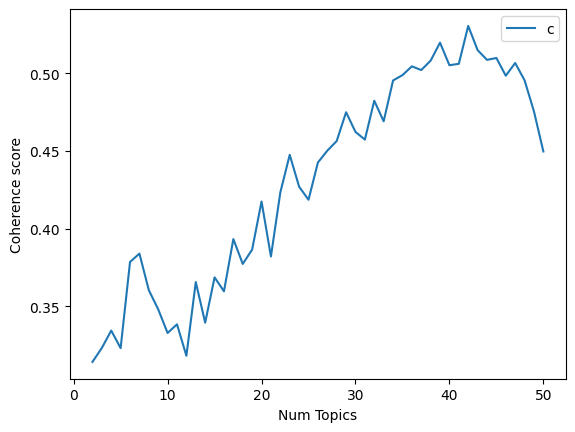

Num Topics = 2  has Coherence Value of 0.3142
Num Topics = 3  has Coherence Value of 0.3232
Num Topics = 4  has Coherence Value of 0.3344
Num Topics = 5  has Coherence Value of 0.3231
Num Topics = 6  has Coherence Value of 0.3786
Num Topics = 7  has Coherence Value of 0.384
Num Topics = 8  has Coherence Value of 0.3604
Num Topics = 9  has Coherence Value of 0.3481
Num Topics = 10  has Coherence Value of 0.3329
Num Topics = 11  has Coherence Value of 0.3384
Num Topics = 12  has Coherence Value of 0.3182
Num Topics = 13  has Coherence Value of 0.3657
Num Topics = 14  has Coherence Value of 0.3395
Num Topics = 15  has Coherence Value of 0.3687
Num Topics = 16  has Coherence Value of 0.3597
Num Topics = 17  has Coherence Value of 0.3933
Num Topics = 18  has Coherence Value of 0.3773
Num Topics = 19  has Coherence Value of 0.3866
Num Topics = 20  has Coherence Value of 0.4175
Num Topics = 21  has Coherence Value of 0.3821
Num Topics = 22  has Coherence Value of 0.4234
Num Topics = 23  has C

In [45]:
# Affichage des résultats
limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))